In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import warnings

from scipy.cluster.hierarchy import dendrogram, linkage


In [2]:
# create a list of files to be analyzed
filelist = os.listdir("../data_full")
filelist.remove(".DS_Store") if ".DS_Store" in filelist else None

In [3]:
# ignore warnings
warnings.filterwarnings("ignore")

In [4]:
# reading in the table occupancy sheet to choose the top genes
genesheet = pd.read_csv("TableOccupancy_full.csv")
genelist = list()
genedict = dict()

In [5]:
# setting the number of genes to be analyzed
top_count = 25

In [6]:
# creating a dictionary for the top genes
genedict = dict((d['Gene'], d['Count']) for d in genesheet.head(top_count)[['Gene', 'Count']].to_dict(orient='records'))

In [7]:
# creating a list of file names to be iterated over

os.chdir("../data_full")

newcolname = list()
filedict = dict()

for file in filelist:
    db = pd.read_csv(file, comment="#")
    filedict[file] = len(db)
    newname = f"{file}, {len(db)}"
    newcolname.append(newname)

newdict = dict(sorted(filedict.items(), key=lambda item: item[1], reverse=True))

filelist = list(newdict.keys())

In [8]:
# initializing lists
r_list = list()
sellist = list()

In [9]:
# calculate Rg values

count = 0

arr = []
r_list = []  
for gene in genedict:
    count += 1
    n = 0
    S_list = list()
    T_list = list()
    for file in filelist:
        db = pd.read_csv(file, comment="#")
        S = 0
        T_list.append(len(db))
        if gene in db["Suggested Match"].values:
            S += 1
        if S > 0:
            n += 1
            
        S_list.append(S)
    arr.append(S_list)
    
    r = 0
    for i in range(n):
        r += S_list[i] / T_list[i]

    r_list.append(r)


In [10]:
# create a dataframe called df_na
nparr = np.array(arr)
df_na = pd.DataFrame(nparr)

In [11]:
# define index and columns of df_na 
index_list = list(genedict.keys())
df_na.index = [index_list]
df_na.columns = [filelist]

In [12]:
# calculate Si values for each dataset
s_list_sum = []
for i in range(len(filelist)):
    s_sum = 0
    for j in range(len(genedict)):
        s_sum += arr[j][i]
    s_list_sum.append(s_sum)

In [13]:
# iterating through each file to calculate selectivity values
for file in filelist:
    db = pd.read_csv(file, comment="#")
    val = 1 / len(db)
    sellist.append(val)

In [14]:
# adding selectivity value to df_na
df_na.loc['st'] = [np.nan] * len(df_na.columns)

In [15]:
# rename df_na indexes
new_index_list = list(genedict.keys())
new_index_list.append("st")
df_na.index = [new_index_list]

In [16]:
# get the list of s/t for all genes
numlist = list()
for i in range(len(filelist)):
    numlist.append(s_list_sum[i] / T_list[i])
    
for i in range(len(filelist)):
    df_na.at["st", filelist[i]] = numlist[i]


In [17]:
# preparing a list of names of datasets based on author, year, and sheet number

colrename = list()
colcheck = list()

for name in newcolname:   
    year = name[:4]
    underscore2 = name.find("_", 5)
    underscore3 = name.find("_", underscore2)
    underscore4 = name.find("_", underscore3)
    blah = name[5:underscore2]
    sanitized_index = name.find("_sanitized")
    sheet_num = name[sanitized_index - 2: sanitized_index]
    if sheet_num == "-1":
        sheet_num = str(1)
    if sheet_num[0] == "_":
        sheet_num = sheet_num[1]
    if sheet_num.isnumeric():
        num = sheet_num
    else:
        num = 1
    
    comma_index = name.find(",")
    genecount = name[comma_index:]
        
    newname = f"{blah}_et_al_{year}_{str(num)}"

    counter = 1
    while newname in colcheck:
        newname = f"{blah}_et_al_{year}_{str(int(num) + counter)}"
        counter += 1

    colcheck.append(newname)
    newname = f"{newname}{genecount}"
    colrename.append(newname)

In [18]:
# renaming the columns with the list of names

newrename = list()    
for i in range(0, len(colrename)):
    newrename.append(f"{colrename[i]}, selectivity={sellist[i]}")
df_na.columns = newrename

In [19]:
# changing the working directory
os.chdir("../code_and_resources")

In [20]:
# Addtion of r-score values

row_dict = dict()

r_list.append(0)

df_na['r'] = r_list

In [21]:
# creating a new list of names for each record
genelist = list(genedict.keys())
newlist = list()
for i in range(top_count):
    newlist.append(f"{genelist[i]}, r-score = {r_list[i]}")
    
newlist.append("st")

In [22]:
# sorting dataframe on values of r and s/t
df_na.index = newlist

df_na = df_na.sort_values(by="st", axis=1, ascending=False)

df_na = df_na.sort_values(by="r", axis=0, ascending=False)

mask = df_na.isna()

In [23]:
# deleting r-score and st after sorting

del df_na['r']

df_na.drop(index=df_na.index[-1], inplace=True)

In [24]:
# replacing 0s with NAs
df_na = df_na.replace(0, np.nan)

In [25]:
# removing all datasets with only null values

null_cols = df_na.columns[df_na.isnull().all()]

df_na = df_na.drop(columns=null_cols)

In [26]:
# renaming the index
df_na.index = df_na.index.str.split(',').str[0]

In [27]:
# creating a list of genes to rename
genes = df_na.index

In [28]:
# reading in Wormbase database
wormbase = pd.read_csv('Wormbase_Gene_Sanitizer_Database_DownloadedOn_10-30-2023.txt', comment="#", sep="\t")

In [29]:
# converting gene names from WBGene names to common names
new_names = list()
for gene in genes:
    result = wormbase.index[wormbase["Public Name For"] == gene].item()
    new_names.append(wormbase.iloc[result, 0])

In [30]:
# replacing WBGene names in df_na with the common gene names
df_na.index = new_names

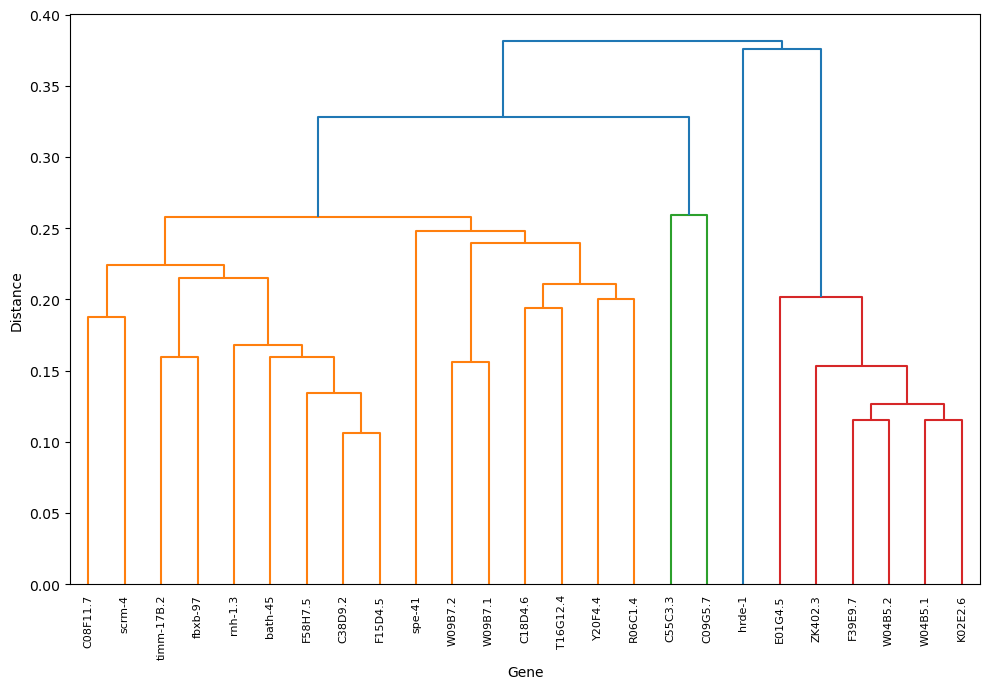

In [32]:
# creating and setting up the dendrogram (Fig 1E)

df_filled = df_na.fillna(0)

data = df_filled.values

Z = linkage(data, method='average', metric='hamming')

plt.figure(figsize=(10, 7))
plt.xlabel('Gene')
plt.ylabel('Distance')
dendrogram(
    Z,
    labels=df_filled.index.astype(str),
    leaf_rotation=90., 
    leaf_font_size=8., 
)
plt.savefig('r25_Jaccard_Distance_Clusters.svg', format='svg', dpi=300)
plt.tight_layout()
plt.show()

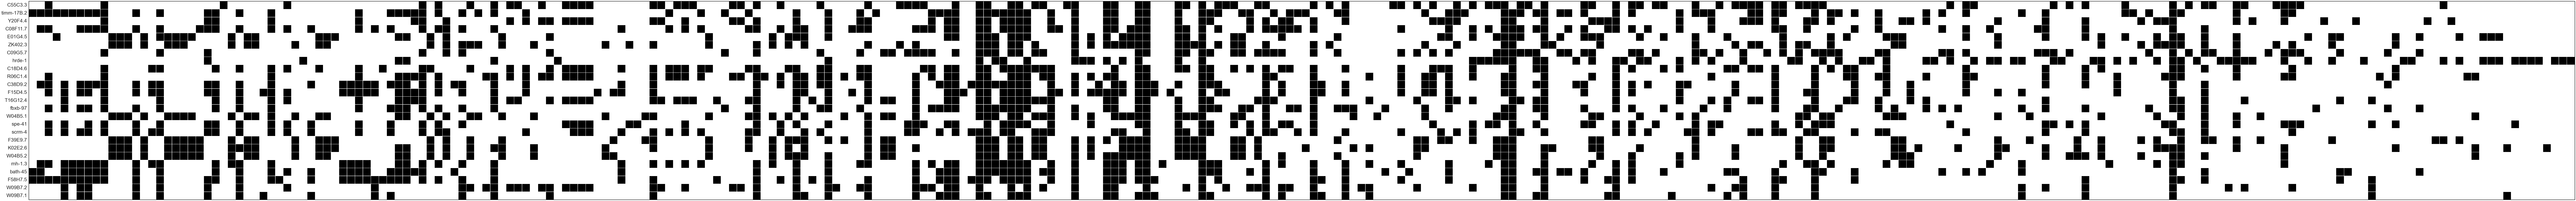

In [33]:
# creating and setting up the heatmap (Fig 1D)

colors = ["black", "white"]
cmap = mcolors.ListedColormap(colors)

num_cols = df_na.shape[1]
num_rows, num_cols = df_na.shape
mask = np.zeros((num_rows, num_cols))
np.fill_diagonal(mask, True)
cmap.set_bad(color='white')

# plot the heatmap
plt.figure(figsize=(250, 250))
sns.set(font_scale=2.5)
hmp = sns.heatmap(df_na, cmap=cmap, linewidths=1, square=True, cbar=False)
for _, spine in hmp.spines.items():
    spine.set_visible(True)
    spine.set_linewidth(2)
    spine.set_edgecolor("black")
hmp.set_xlabel("")
hmp.set_ylabel("")
hmp.set_title("")
plt.savefig('r25_heatmap_of_tables.svg', format='svg', dpi=300)
plt.xticks([])
plt.show()